# Investigating Fandango Movie Ratings

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com/) is an online movie ratings aggregator). He published his analysis in [this article](https://fivethirtyeight.com/features/fandango-movies-ratings/) — a great piece of data journalism that's totally worth reading.

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although I can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project, I'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

Because I want to find out whether the Fandango's rating system changed after Hickey's analysis, I'm interested in sampling the population at two different periods in time — previous and after Hickey's analysis — so I can compare the two periods.

## Understanding the Data

I'll work with two samples of movie ratings: the data in one sample was collected previous to Hickey's analysis, while the other sample was collected after. 

In Hickey's article it's written that he used the following sampling criteria:

* The movie must have had tickets on sale in 2015.
* The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).

The sampling was clearly not random because not every movie had the same chance to be included in the sample. It seems more likely that this sample isn't representative of the entire population I'm interested to describe, mostly because this sample is subject to *temporal trends*.

The sampling conditions for the other sample were:

* The movie must have been released in 2016 or later.
* The movie must have had a considerable number of votes and reviews (unclear how many).

This second sample is also subject to temporal trends and it's unlikely to be representative of the population of interest.

Unfortunately these samples don't seem too useful for us.

## Changing the Goal of the Analysis

At this point, I can either collect new data or change the goal of the analysis. I choose the latter.

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, the new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for the initial goal.

# Exploring the Data

Let's start by reading in the two samples (which are stored as CSV files) and getting familiar with their structure.

In [37]:
import pandas as pd
pd.options.display.max_columns = 100  # Avoid having displayed truncated output

previous = pd.read_csv('fandango_score_comparison.csv')
after = pd.read_csv('movie_ratings_16_17.csv')

previous.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,3.30,3.55,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,3.35,3.75,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,3.20,4.05,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [38]:
after.head(3)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.5,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.0,2.35,2.5,3.5,2.0,2.5


Below I isolate only the columns that provide information about Fandango to make the relevant data more readily available for later use. I'll make copies to avoid any `SettingWithCopyWarning` later on. 

In [39]:
fandango_previous = previous[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes',
                             'Fandango_Difference']].copy()
fandango_after = after[['movie', 'year', 'fandango']].copy()

fandango_previous.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [40]:
fandango_after.head(3)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


## Isolating the Samples We Need

We have two populations of interest:

1. All Fandango's ratings for popular movies released in 2015.
2. All Fandango's ratings for popular movies released in 2016.

I need to be clear about what counts as popular movies. I'll use Hickey's benchmark of 30 fan ratings and count a movie as popular only if it has 30 fan ratings or more on Fandango's website.

Although one of the sampling criteria in the second sample is movie popularity, the sample doesn't provide information about the number of fan ratings. I should be skeptical once more and ask whether this sample is truly representative and contains popular movies (movies with over 30 fan ratings).

One quick way to check the representativity of this sample is to sample randomly 10 movies from it and then check the number of fan ratings on Fandango's website. Ideally, at least 8 out of the 10 movies have 30 fan ratings or more.

In [41]:
fandango_after.sample(10, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


Using a value of 1 as the random seed is good practice because it suggests that I wasn't trying out various random seeds just to get a favorable sample.

These are the fan ratings I found:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-amwm">Movie</th>
    <th class="tg-amwm">Fan ratings</th>
  </tr>
  <tr>
    <td class="tg-baqh">Mechanic: Resurrection</td>
    <td class="tg-baqh">2247</td>
  </tr>
  <tr>
    <td class="tg-baqh">Warcraft</td>
    <td class="tg-baqh">7271</td>
  </tr>
  <tr>
    <td class="tg-baqh">Max Steel</td>
    <td class="tg-baqh">493</td>
  </tr>
  <tr>
    <td class="tg-baqh">Me Before You</td>
    <td class="tg-baqh">5263</td>
  </tr>
  <tr>
    <td class="tg-baqh">Fantastic Beasts and Where to Find Them</td>
    <td class="tg-baqh">13400</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Cell</td>
    <td class="tg-yw4l">17</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Genius</td>
    <td class="tg-yw4l">127</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Sully</td>
    <td class="tg-yw4l">11877</td>
  </tr>
  <tr>
    <td class="tg-yw4l">A Hologram for the King	</td>
    <td class="tg-yw4l">500</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Captain America: Civil War</td>
    <td class="tg-yw4l">35057</td>
  </tr>
</table>


90% of the movies in this sample are popular. This is enough and I move forward with a bit more confidence.

If you explore the two data sets, you'll notice that there are movies with a releasing year different than 2015 or 2016. For my purposes, I'll need to isolate only the movies released in 2015 and 2016.

Let's start with Hickey's data set and isolate only the movies released in 2015. There's no special column for the releasing year, but I can extract it from the strings in the `FILM` column.

In [42]:
fandango_previous.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5


In [43]:
fandango_previous['Year'] = fandango_previous['FILM'].str[-5:-1]
fandango_previous.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015


Let's examine the frequency distribution for the `Year` column and then isolate the movies released in 2015.

In [44]:
fandango_previous['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [45]:
fandango_2015 = fandango_previous[fandango_previous['Year'] == '2015'].copy()
fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

Now let's isolate the movies in the other data set.

In [46]:
fandango_after.head(2)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5


In [47]:
fandango_after['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [48]:
fandango_2016 = fandango_after[fandango_after['year'] == 2016].copy()
fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

# Data Analysis

## Comparing Distribution Shapes for 2015 and 2016

The aim is to figure out whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. One way to go about is to analyze and compare the distributions of movie ratings for the two samples.

I'll start with comparing the shape of the two distributions using kernel density plots.

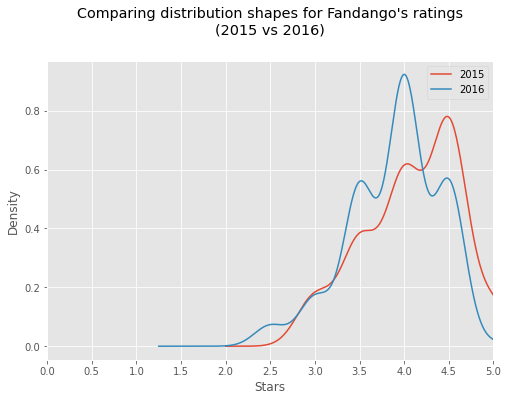

In [49]:
import matplotlib.pyplot as plt
from numpy import arange
%matplotlib inline
plt.style.use('ggplot')

fandango_2015['Fandango_Stars'].plot.kde(label = '2015', legend = True, figsize = (8,5.5))
fandango_2016['fandango'].plot.kde(label = '2016', legend = True)

plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)",
          y = 1.07) # the `y` parameter pads the title upward
plt.xlabel('Stars')
plt.xlim(0,5) # because ratings start at 0 and end at 5
plt.xticks(arange(0,5.1,.5))
plt.show()

Two aspects are striking on the figure above:
* Both distributions are strongly left skewed.
* The 2016 distribution is slightly shifted to the left relative to the 2015 distribution.

The left skew suggests that movies on Fandango are given mostly high and very high fan ratings.

The slight left shift of the 2016 distribution is very interesting for the analysis. It shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.

## Comparing Relative Frequencies

Let's examine the frequency tables of the two distributions to analyze some numbers. Because the data sets have different numbers of movies, I normalize the tables and show percentages instead.

In [50]:
print('2015' + '\n' + '-' * 16)
fandango_2015['Fandango_Stars'].value_counts(normalize = True).sort_index() * 100

2015
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [51]:
print('2016' + '\n' + '-' * 16)
fandango_2016['fandango'].value_counts(normalize = True).sort_index() * 100

2016
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2016, very high ratings (4.5 and 5 stars) had significantly lower percentages compared to 2015. In 2016, under 1% of the movies had a perfect rating of 5 stars, compared to 2015 when the percentage was close to 7%. Ratings of 4.5 were also more popular in 2015 — there were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

The minimum rating is also lower in 2016 — 2.5 instead of 3 stars, the minimum of 2015. There clearly is a difference between the two frequency distributions.

For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings and this challenges the direction of the change I saw on the kernel density plots.

## Determining the Direction of the Change

Let's take a couple of summary metrics to get a more precise picture about the direction of the change. In what follows, I'll compute the mean, the median, and the mode for both distributions and then use a bar graph to plot the values.

In [52]:
mean_2015 = fandango_2015['Fandango_Stars'].mean()
mean_2016 = fandango_2016['fandango'].mean()

median_2015 = fandango_2015['Fandango_Stars'].median()
median_2016 = fandango_2016['fandango'].median()

mode_2015 = fandango_2015['Fandango_Stars'].mode()[0]
mode_2016 = fandango_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


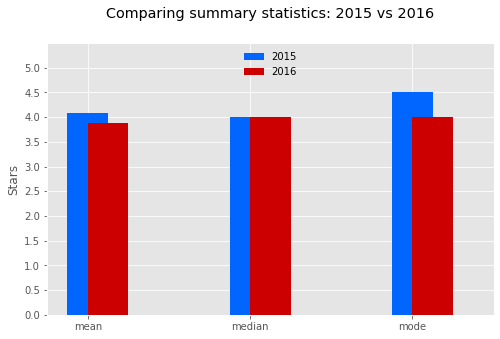

In [53]:
plt.style.use('ggplot')
summary['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = .25)
summary['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

The mean rating was lower in 2016 with approximately 0.2. This means a drop of almost 5% relative to the mean rating in 2015.

In [54]:
(summary.loc['mean'][0] - summary.loc['mean'][1]) / summary.loc['mean'][0]

0.04842683568951993

While the median is the same for both distributions, the mode is lower in 2016 by 0.5. Coupled with what we saw for the mean, the direction of the change on the kernel density plot is confirmed: on average, popular movies released in 2016 were rated slightly lower than popular movies released in 2015.

# Conclusion

The analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. I also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

I cannot be completely sure what caused the change, but the chances are very high that it was caused by Fandango fixing the biased rating system after Hickey's analysis.